In [1]:
import torch
from pytorch_transformers import *

In [2]:
# 模型改为bert-base-chinese，可训练中文数据
model_class, tokenizer_class, pretrained_weights=(BertModel,BertTokenizer,'bert-base-uncased')

In [3]:
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [4]:
model = model_class.from_pretrained(pretrained_weights)

In [5]:
input_ids = torch.tensor([tokenizer.encode("Here is some text to encode")])

In [6]:
input_ids

tensor([[ 2182,  2003,  2070,  3793,  2000,  4372, 16044]])

In [7]:
with torch.no_grad():
        last_hidden_states = model(input_ids)[0]  # Models outputs are now tuples

In [8]:
last_hidden_states.shape

torch.Size([1, 7, 768])

In [9]:
model = model_class.from_pretrained(pretrained_weights,
                                    output_hidden_states=True,
                                    output_attentions=True)
input_ids = torch.tensor([tokenizer.encode("Let's see all hidden-states and attentions on this text")])
all_hidden_states, all_attentions = model(input_ids)[-2:]

In [10]:
model = model_class.from_pretrained(pretrained_weights, torchscript=True)
traced_model = torch.jit.trace(model, (input_ids,))

测试样例（windows环境） 

    set  GLUE_DIR=D:\conda_venv\pytorch-transformers\examples\tests_samples
    set TASK_NAME=MRPC

    python run_glue.py --model_type bert --model_name_or_path bert-base-uncased --task_name %TASK_NAME% --do_train  --do_eval  --do_lower_case --data_dir %GLUE_DIR%\%TASK_NAME% --max_seq_length 128 --per_gpu_eval_batch_size=8  --per_gpu_train_batch_size=8  --learning_rate 2e-5 --num_train_epochs 3.0 --output_dir %GLUE_DIR%\output\%TASK_NAME%
    


07/28/2019 11:03:00 - INFO - __main__ -   ***** Eval results  *****  
07/28/2019 11:03:00 - INFO - __main__ -     acc = 0.5  
07/28/2019 11:03:00 - INFO - __main__ -     acc_and_f1 = 0.25  
07/28/2019 11:03:00 - INFO - __main__ -     f1 = 0.0  

测试成功

## 使用的数据集
https://github.com/SophonPlus/ChineseNlpCorpus 里的外卖平台收集的用户评价 

# waimai_10k 说明
0. **下载地址：** [Github](https://github.com/SophonPlus/ChineseNlpCorpus/raw/master/datasets/waimai_10k/waimai_10k.csv)
1. **数据概览：** 某外卖平台收集的用户评价，正向 4000 条，负向 约 8000 条
2. **推荐实验：** 情感/观点/评论 倾向性分析
2. **数据来源：** 某外卖平台
3. **原数据集：** [中文短文本情感分析语料 外卖评价](https://download.csdn.net/download/cstkl/10236683)，网上搜集，具体作者、来源不详
4. **加工处理：**
    1. 将原来 2 个文件整合到 1 个文件中
    2. 去重

In [11]:
import pandas as pd
pd_all = pd.read_csv('waimai_10k.csv')

In [12]:
print('评论数目（总体）：%d' % pd_all.shape[0])
print('评论数目（正向）：%d' % pd_all[pd_all.label==1].shape[0])
print('评论数目（负向）：%d' % pd_all[pd_all.label==0].shape[0])

评论数目（总体）：11987
评论数目（正向）：4000
评论数目（负向）：7987


## 字段说明

| 字段 | 说明 |
| ---- | ---- |
| label | 1 表示正向评论，0 表示负向评论 |
| review | 评论内容 |

In [13]:
pd_all.sample(20)

label                                             review
2529       1                                     非常满意，感谢送货员和商家！
1844       1                                送餐很快，卷饼里面感觉再多点酱汁比较好
2479       1                                         包装不错，干净卫生，
4782       0                                             菜不是很好吃
10845      0                                      味道很一般，比老车记差远了
11789      0                               等了一个半小时还不送。电话是空号。呵呵了
3359       1                恩还不错，就是订餐的时候系统匹配错误。打电话调节了一下，从新下单才订上
5158       0                                      味道有点淡，不过服务很好。
10380      0                                     菜都凉的，感觉没熟，量太少！
117        1                                        很快。。布丁奶茶贼好喝
1150       1                    卷饼还行，粥太难喝，皮蛋瘦肉粥太腥了，还得自己下楼取，勉强好评
8511       0                      东西很棒，送餐服务很不好。迟到半个小时，也没表达什么歉意。
1067       1                                            好吃,速度快！
1529       1  看到来送外卖的大叔疲倦的样子，真是各行各业都不容易，国家何时能让大家共同富裕起来，至少别等级...
4405       0                                              太油腻了。
6085       0                                       服务态度很好，东西也好吃
6692       0                                    下次能送早点就好啦,快饿过劲啦
3327       1                                          很好,配送员也很好
4228       0                                 送餐没准！！！想送就送，不想送就不送
4563       0  还不错吧，配送小哥态度很好，速度略慢...肘子卷饼味道还是可以的，但是总觉得不像肘子更像红烧...

# 2. 构造平衡语料

In [14]:
pd_positive = pd_all[pd_all.label==1]
pd_negative = pd_all[pd_all.label==0]

def get_balance_corpus(corpus_size, corpus_pos, corpus_neg):
    sample_size = corpus_size // 2
    pd_corpus_balance = pd.concat([corpus_pos.sample(sample_size, replace=corpus_pos.shape[0]<sample_size), \
                                   corpus_neg.sample(sample_size, replace=corpus_neg.shape[0]<sample_size)])
    
    print('评论数目（总体）：%d' % pd_corpus_balance.shape[0])
    print('评论数目（正向）：%d' % pd_corpus_balance[pd_corpus_balance.label==1].shape[0])
    print('评论数目（负向）：%d' % pd_corpus_balance[pd_corpus_balance.label==0].shape[0])    
    
    return pd_corpus_balance

In [15]:
waimai_10k_ba_4000 = get_balance_corpus(8000, pd_positive, pd_negative)

waimai_10k_ba_4000.sample(10)

评论数目（总体）：8000
评论数目（正向）：4000
评论数目（负向）：4000


label                                             review
7103       0                            肉，豆腐，蔬菜都不新鲜、味道差极，关门少骗人吧
708        1                                 很配送员很好，辛苦了，面也很好，很快
3133       1                                        很好吃，以后快餐就它了
1077       1  味道还行，锡纸包着，还能加热。皮蛋瘦肉粥做的很好比嘉和一品好吃。包装很精致。还有一次性手套，...
1930       1  1、尖椒土豆丝，说好的尖椒呢。。。全是土豆丝。,2、大号的卷饼，有点太大了。。。。。。,3、粥不错
3662       1                                        湄洲的饭菜还是比较好的
11265      0                                       接电话的小妹态度很不好。
7153       0                                          配料太多，味道一般
2598       1                                        送货真的很快。。。。。
10399      0                                冷面难吃死了，还不如方便面，太垃圾了，

In [16]:
import matplotlib.pyplot as plt

评论长度大多集中在100以内，由于bert测试样例使用的是长度是128，则将句子最长长度设定为128

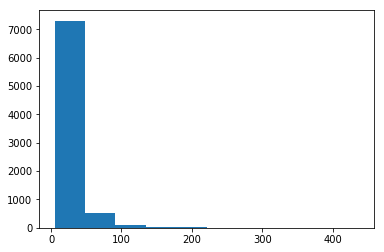

In [17]:
plt.hist(waimai_10k_ba_4000['review'].apply(lambda x:len(x)).values)
plt.show()

In [18]:
waimai_10k_ba_4000['review'].apply(lambda x:len(x)).quantile(0.95)

62.0

In [19]:
sum(waimai_10k_ba_4000['review'].apply(lambda x:len(x))<=128)/len(waimai_10k_ba_4000)

0.992

In [20]:
max_seq_length=128

# 3. 构造训练BERT所需要的数据集

查看HuggingFace的样本实例
https://github.com/huggingface/pytorch-transformers/blob/master/examples/utils_glue.py

In [21]:
class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

这意味着我们需要将我们的数据转换成ID,text_a.text_b,label的格式

In [22]:
train_df_bert = pd.DataFrame({
    'id':range(len(waimai_10k_ba_4000)),
    'text_a':waimai_10k_ba_4000['review'].str.strip(),
    'text_b':'None',
    'label': waimai_10k_ba_4000['label']
})

In [23]:
train_df_bert.head()

id                                         text_a text_b  label
478    0             很好！份量很足，香干回锅肉里的萝卜干很好吃，每份饭还送了咖啡，谢谢！   None      1
3753   1             速度很快，送了蘸酱，但是上次电话订餐没有送。孩子喜欢吃马盏糕和小笼包   None      1
609    2                                    辣！很辣！很过瘾的辣！   None      1
1935   3                               挺好吃,就是小贵,如果没立减的话   None      1
902    4  送餐小哥态度特别好！好多肉呀好吃好吃！可我以为是可以选米饭换卷饼的？还在订单里自信地备注了   None      1

查看DataProcessor发现，读取数据是需要tsv格式，utf-8的文件，我们按80%，20%的比例分割训练集与验证集，再将文件保存为tsv格式，命名改为train.tsv与dev.tsv（或者在自己的DataProcessor改写）

In [24]:
class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r", encoding="utf-8-sig") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines

In [25]:
train_df_bert=train_df_bert.sample(frac=1.0).reset_index(drop=True)
train_df=train_df_bert[:int(len(train_df_bert)*0.8)]
dev_df = train_df_bert[int(len(train_df_bert)*0.8):]

In [26]:
train_df.head()

id                                   text_a text_b  label
0  7446  麻酱两块钱，给了一瓶盖子量！地瓜片是生的！超级大差评，说的微辣，一打开全是辣油   None      0
1  1166                             纯肉得，有种肉夹馍的味道   None      1
2  1736                               味道不错，速度很快。   None      1
3  1859                         骑士太给力了，送餐快，直接到门口   None      1
4  5133                              送餐太慢，送过来都凉了   None      0

In [27]:
train_df.to_csv('data/train.tsv', sep='\t', index=False, header=True)
dev_df.to_csv('data/dev.tsv', sep='\t', index=False, header=True)

查看官方Mrpc数据集的示例，复制代码并改写_create_examples函数

In [28]:
class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = line[0]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples

In [29]:
class WaimaiProcessor(DataProcessor):
    """Processor for the WaimaiProcessor data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[1]
            label = line[3]
            examples.append(
                InputExample(guid=guid, text_a=text_a, label=label))
        return examples

现在，我们将数据读取并转换为了InputExample格式，但是BERT模型并不能直接使用这个格式，我们还需要做转换改为InputFeatures的格式

In [30]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id

这里面需要查看convert_examples_to_features，_truncate_seq_pair函数

In [31]:
def convert_examples_to_features(examples, label_list, max_seq_length,
                                 tokenizer, output_mode,
                                 cls_token_at_end=False, pad_on_left=False,
                                 cls_token='[CLS]', sep_token='[SEP]', pad_token=0,
                                 sequence_a_segment_id=0, sequence_b_segment_id=1,
                                 cls_token_segment_id=1, pad_token_segment_id=0,
                                 mask_padding_with_zero=True):
    """ Loads a data file into a list of `InputBatch`s
        `cls_token_at_end` define the location of the CLS token:
            - False (Default, BERT/XLM pattern): [CLS] + A + [SEP] + B + [SEP]
            - True (XLNet/GPT pattern): A + [SEP] + B + [SEP] + [CLS]
        `cls_token_segment_id` define the segment id associated to the CLS token (0 for BERT, 2 for XLNet)
    """

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        if ex_index % 10000 == 0:
            logger.info("Writing example %d of %d" % (ex_index, len(examples)))

        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids:   0   0   0   0  0     0   0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambiguously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = tokens_a + [sep_token]
        segment_ids = [sequence_a_segment_id] * len(tokens)

        if tokens_b:
            tokens += tokens_b + [sep_token]
            segment_ids += [sequence_b_segment_id] * (len(tokens_b) + 1)

        if cls_token_at_end:
            tokens = tokens + [cls_token]
            segment_ids = segment_ids + [cls_token_segment_id]
        else:
            tokens = [cls_token] + tokens
            segment_ids = [cls_token_segment_id] + segment_ids

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1 if mask_padding_with_zero else 0] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding_length = max_seq_length - len(input_ids)
        if pad_on_left:
            input_ids = ([pad_token] * padding_length) + input_ids
            input_mask = ([0 if mask_padding_with_zero else 1] * padding_length) + input_mask
            segment_ids = ([pad_token_segment_id] * padding_length) + segment_ids
        else:
            input_ids = input_ids + ([pad_token] * padding_length)
            input_mask = input_mask + ([0 if mask_padding_with_zero else 1] * padding_length)
            segment_ids = segment_ids + ([pad_token_segment_id] * padding_length)

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        if output_mode == "classification":
            label_id = label_map[example.label]
        elif output_mode == "regression":
            label_id = float(example.label)
        else:
            raise KeyError(output_mode)

        if ex_index < 5:
            logger.info("*** Example ***")
            logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info("segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features

简单的说，就是把我们的评论数据进行分词，并加上标识符

In [31]:
# 模型已改为bert-base-chinese，可训练中文数据
model_class, tokenizer_class, pretrained_weights=(BertModel,BertTokenizer,'bert-base-chinese')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
A = tokenizer.tokenize('这家店不好吃')
cls_token='[CLS]'
sep_token='[SEP]'
add_token_sentences = [cls_token] + A + [sep_token] 

In [32]:
add_token_sentences

['[CLS]', '这', '家', '店', '不', '好', '吃', '[SEP]']

[CLS] + A + [SEP] + B + [SEP]

下面是segment_ids

In [33]:
# The convention in BERT is:
# (a) For sequence pairs:
#  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
#  type_ids:   0   0  0    0    0     0       0   0   1  1  1  1   1   1
# (b) For single sequences:
#  tokens:   [CLS] the dog is hairy . [SEP]
#  type_ids:   0   0   0   0  0     0   0

再将add_token_sentences转为数字格式，最后将input_ids补充padding就行了

In [35]:
input_ids = tokenizer.convert_tokens_to_ids(add_token_sentences)
pad_token=0
padding_length=max_seq_length-len(input_ids)

In [36]:
input_ids = input_ids + ([pad_token] * padding_length)

In [37]:
input_ids

[101,
 6822,
 2158,
 2422,
 680,
 1963,
 1392,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

转向训练部分  
作者原来使用的是BERT官方的分类器，但经过B站up主espresso:https://www.bilibili.com/video/av601688911 的实践发现，原来的网络结构在中文训练集上效果并不好，可以看里面视频的改进，主要是进行mean与maxpooling再合并，下面列举出他的实现与官方实现，后续进行测试，看看哪一个效果较好  
from pytorch_transformers import BertForSequenceClassification

In [38]:
from torch import nn
#from models.bert_model import BertModel
"""使用mean max pool的方式进行情感分析"""
class Bert_Sentiment_Analysis(nn.Module):
    def __init__(self, config):
        super(Bert_Sentiment_Analysis, self).__init__()
        self.bert = BertModel(config)
        self.dense = nn.Linear(config.hidden_size * 2, config.hidden_size)
        self.final_dense = nn.Linear(config.hidden_size, 1)
        self.activation = nn.Sigmoid()

    def compute_loss(self, predictions, labels):
        # 将预测和标记的维度展平, 防止出现维度不一致
        predictions = predictions.view(-1)
        labels = labels.float().view(-1)
        epsilon = 1e-8
        # 交叉熵
        loss =\
            - labels * torch.log(predictions + epsilon) - \
            (torch.tensor(1.0) - labels) * torch.log(torch.tensor(1.0) - predictions + epsilon)
        # 求均值, 并返回可以反传的loss
        # loss为一个实数
        loss = torch.mean(loss)
        return loss

    def forward(self, text_input, positional_enc, labels=None):
        encoded_layers, _ = self.bert(text_input, positional_enc,
                                    output_all_encoded_layers=True)
        sequence_output = encoded_layers[2]
        # # sequence_output的维度是[batch_size, seq_len, embed_dim]
        avg_pooled = sequence_output.mean(1)
        max_pooled = torch.max(sequence_output, dim=1)
        pooled = torch.cat((avg_pooled, max_pooled[0]), dim=1)
        pooled = self.dense(pooled)



        # 下面是[batch_size, hidden_dim * 2] 到 [batch_size, 1]的映射
        # 我们在这里要解决的是二分类问题

        predictions = self.final_dense(pooled)

        # 用sigmoid函数做激活, 返回0-1之间的值
        predictions = self.activation(predictions)
        if labels is not None:
            # 计算loss
            loss = self.compute_loss(predictions, labels)
            return predictions, loss
        else:
            return predictions

In [39]:
class BertForSequenceClassification(BertPreTrainedModel):
    r"""
        **labels**: (`optional`) ``torch.LongTensor`` of shape ``(batch_size,)``:
            Labels for computing the sequence classification/regression loss.
            Indices should be in ``[0, ..., config.num_labels]``.
            If ``config.num_labels == 1`` a regression loss is computed (Mean-Square loss),
            If ``config.num_labels > 1`` a classification loss is computed (Cross-Entropy).

    Outputs: `Tuple` comprising various elements depending on the configuration (config) and inputs:
        **loss**: (`optional`, returned when ``labels`` is provided) ``torch.FloatTensor`` of shape ``(1,)``:
            Classification (or regression if config.num_labels==1) loss.
        **logits**: ``torch.FloatTensor`` of shape ``(batch_size, config.num_labels)``
            Classification (or regression if config.num_labels==1) scores (before SoftMax).
        **hidden_states**: (`optional`, returned when ``config.output_hidden_states=True``)
            list of ``torch.FloatTensor`` (one for the output of each layer + the output of the embeddings)
            of shape ``(batch_size, sequence_length, hidden_size)``:
            Hidden-states of the model at the output of each layer plus the initial embedding outputs.
        **attentions**: (`optional`, returned when ``config.output_attentions=True``)
            list of ``torch.FloatTensor`` (one for each layer) of shape ``(batch_size, num_heads, sequence_length, sequence_length)``:
            Attentions weights after the attention softmax, used to compute the weighted average in the self-attention heads.

    Examples::

        >>> config = BertConfig.from_pretrained('bert-base-uncased')
        >>> tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        >>> 
        >>> model = BertForSequenceClassification(config)
        >>> input_ids = torch.tensor(tokenizer.encode("Hello, my dog is cute")).unsqueeze(0)  # Batch size 1
        >>> labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
        >>> outputs = model(input_ids, labels=labels)
        >>> loss, logits = outputs[:2]

    """
    def __init__(self, config):
        super(BertForSequenceClassification, self).__init__(config)
        self.num_labels = config.num_labels

        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, self.config.num_labels)

        self.apply(self.init_weights)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None, labels=None,
                position_ids=None, head_mask=None):
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        pooled_output = outputs[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        outputs = (logits,) + outputs[2:]  # add hidden states and attention if they are here

        if labels is not None:
            if self.num_labels == 1:
                #  We are doing regression
                loss_fct = MSELoss()
                loss = loss_fct(logits.view(-1), labels.view(-1))
            else:
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            outputs = (loss,) + outputs

        return outputs  # (loss), logits, (hidden_states), (attentions)

NameError: name 'BertPreTrainedModel' is not defined

这里先使用官方的实现，把run_glue.py需要的内容裁剪出来

In [40]:
from __future__ import absolute_import, division, print_function

import argparse
import glob
import logging
import os
import random

import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tensorboardX import SummaryWriter
from tqdm import tqdm, trange
from pytorch_transformers import (WEIGHTS_NAME, BertConfig,BertForSequenceClassification, BertTokenizer)
from pytorch_transformers import AdamW, WarmupLinearSchedule

# from utils_glue import (compute_metrics, convert_examples_to_features,
#                         output_modes, processors)

logger = logging.getLogger(__name__)

ALL_MODELS = tuple(BertConfig.pretrained_config_archive_map.keys())

MODEL_CLASSES = {
    'bert': (BertConfig, BertForSequenceClassification, BertTokenizer)
}

In [41]:
ALL_MODELS

('bert-base-uncased',
 'bert-large-uncased',
 'bert-base-cased',
 'bert-large-cased',
 'bert-base-multilingual-uncased',
 'bert-base-multilingual-cased',
 'bert-base-chinese',
 'bert-base-german-cased',
 'bert-large-uncased-whole-word-masking',
 'bert-large-cased-whole-word-masking',
 'bert-large-uncased-whole-word-masking-finetuned-squad',
 'bert-large-cased-whole-word-masking-finetuned-squad',
 'bert-base-cased-finetuned-mrpc')

In [42]:
def simple_accuracy(preds, labels):
    return (preds == labels).mean()

def compute_metrics(task_name, preds, labels):
    assert len(preds) == len(labels)
    return {"acc": simple_accuracy(preds, labels)}

In [43]:
output_modes = {
    "waimai": "classification"
}

GLUE_TASKS_NUM_LABELS = {
    "waimai": 2
}
processors = {
    "waimai": WaimaiProcessor,
}

其他代码放在run_waimai.py中，或者直接看run_glue.py  
下面附上参数配置说明  
refer:https://blog.csdn.net/whuty1304/article/details/89457014

main函数一开始就是一大段的参数设置，我们需要重点关注的主要包括以下几个参数：

- data_dir： 输入数据的文件目录，里面应该包含train val test三个文件分别用于训练、验证、测试
- bert_model： 所使用的bert预训练模型，这里我们一般用到的是bert-base-chinese
- task_name：训练任务的名称，其实就是用来获取我们为每个任务自定义的Processor类
- model_save_pth： 训练完的模型参数的保存地址
- max_seq_length：字符串的最大长度，越长需要越多的计算量，一般设置64或128，这里是128
- do_train/do_eval：是否训练或验证
- learning_rate：学习率，论文推荐了几个，5e-5, 3e-5, 2e-5
- no_cuda：是否使用GPU加速，如果设置为False，双重否定表肯定，表示使用GPU训练模型
- local_rank：这个参数可以不改，默认设置为-1
- per_gpu_eval_batch_size 这里用的是CPU，将batch改为16或8（虽然参数写的是gpu，但如果没有gpu，会用cpu运算）
- per_gpu_train_batch_size  这里用的是CPU，将batch改为16或8

运行参数
--data_dir D:\project\bert_classify\data  
--model_type bert  
--model_name_or_path bert-base-chinese
--task_name waimai  
--output_dir D:\project\bert_classify\output  
--do_train  
--do_eval   
--per_gpu_eval_batch_size=16
--per_gpu_train_batch_size=16  
--num_train_epochs  50  
--do_lower_case

运行结果：由于是在自己笔记本上跑的，用的CPU,跑一个epoch都要3个多小时。。。
跑出来的结果感觉也不太理想，只有56.8%，后续如果有GPU环境的话，再试试更多的epochs，改用B站UP主设计的网络结构，或者收集更多的评论数据了
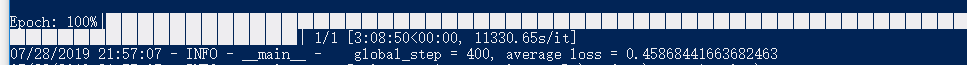
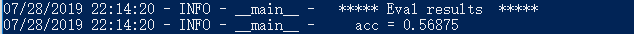

加载已经训练好的模型，发现测试的结果也是60%

In [89]:
tokenizer = BertTokenizer.from_pretrained(r'D:\project\bert_classify\output')

In [109]:
model = BertForSequenceClassification.from_pretrained(r'D:\project\bert_classify\output')

In [110]:
model.to("cpu")

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(21128, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [126]:
def sentiment_judge(sentence):
    max_seq_length =128
    A = tokenizer.tokenize(sentence)
    cls_token='[CLS]'
    sep_token='[SEP]'
    add_token_sentences = [cls_token] + A + [sep_token] 
    input_ids = tokenizer.convert_tokens_to_ids(add_token_sentences)
    pad_token=0
    padding_length=max_seq_length-len(input_ids)
    input_ids = input_ids + ([pad_token] * padding_length)
    a= torch.tensor([input_ids], dtype=torch.long)
    outputs= model(input_ids=a)
    print(sentence+':'+predict_judge(outputs))

In [151]:
def predict_judge(outputs):
    if int(torch.argmax(outputs[0])) ==1:
        return '好评'
    else:
        return '差评'

In [156]:
good_sentence_list = ['腊牛肉好吃极了！','百度小哥速度超快提前半小时到，非常感谢，这么冷的天真是不容易，再次感谢','不错滴，锡纸包住的创意很好，还配了手套，妈妈再也不用担心我吃个卷饼吃的哪哪都是了，送餐小哥的态度也很好，赞一个～',
                     '配送及时，态度很好，五星好评','今天下雪。天气寒冷。辛苦送餐员了']
for sentence in good_sentence_list:
    sentiment_judge(sentence)

腊牛肉好吃极了！:好评
百度小哥速度超快提前半小时到，非常感谢，这么冷的天真是不容易，再次感谢:差评
不错滴，锡纸包住的创意很好，还配了手套，妈妈再也不用担心我吃个卷饼吃的哪哪都是了，送餐小哥的态度也很好，赞一个～:差评
配送及时，态度很好，五星好评:好评
今天下雪。天气寒冷。辛苦送餐员了:好评


In [157]:
bad_sentence_list = ['送的时间太晚了，一个小时才送来','送货超慢，已经都凉透了，饼硬的不行。','送餐现在越来越不靠谱','下单一个半小时才确认，送餐太慢了',
                    '盖饭洒了，面也洒了成一坨不能吃了，最失败的一次订餐']
for sentence in bad_sentence_list:
    sentiment_judge(sentence)

送的时间太晚了，一个小时才送来:差评
送货超慢，已经都凉透了，饼硬的不行。:好评
送餐现在越来越不靠谱:好评
下单一个半小时才确认，送餐太慢了:差评
盖饭洒了，面也洒了成一坨不能吃了，最失败的一次订餐:差评


后期计划：  
改进分类器的结构  
使用中文全词覆盖BERT（Chinese BERT with Whole Word Masking） 地址：https://github.com/ymcui/Chinese-BERT-wwm  
训练更多的epoch  
收集更多的外卖评论数据